<a href="https://colab.research.google.com/github/Evanaxander/Predicting-no-shows-in-patients/blob/main/healthcare_noshows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 Data Preprocessing

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [ ]:
df = pd.read_csv('healthcare_noshows.csv')

In [ ]:
print(df.columns)

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'Showed_up',
       'Date.diff'],
      dtype='object')


In [ ]:
# Drop unnecessary columns (PatientId and AppointmentID are not useful for prediction)
df = df.drop(['PatientId', 'AppointmentID'], axis=1)

In [ ]:
# Convert ScheduledDay and AppointmentDay to datetime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

# Extract useful features from datetime columns
df['ScheduledDay_DayOfWeek'] = df['ScheduledDay'].dt.dayofweek
df['ScheduledDay_Hour'] = df['ScheduledDay'].dt.hour
df['AppointmentDay_DayOfWeek'] = df['AppointmentDay'].dt.dayofweek

# Calculate the difference between ScheduledDay and AppointmentDay (in days)
df['DaysUntilAppointment'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days

# Drop the original datetime columns
df = df.drop(['ScheduledDay', 'AppointmentDay'], axis=1)

In [ ]:
df = df.fillna(df.mode().iloc[0])  # Fill with mode for categorical columns

# Separate features and target variable
X = df.drop('Scholarship', axis=1)
y = df['Scholarship']

In [ ]:
categorical_features = ['Gender', 'Neighbourhood', 'scholarship', 'Hipertension', 'Diabetes']

In [ ]:
categorical_features = ['Gender', 'Neighbourhood', 'Hipertension', 'Diabetes']

In [ ]:
df['Scholarship'] = 0  # Add the column with default value 0

In [ ]:
# Define preprocessing for numerical and categorical features
numerical_features = ['Age', 'DaysUntilAppointment', 'ScheduledDay_DayOfWeek', 'ScheduledDay_Hour', 'AppointmentDay_DayOfWeek']
categorical_features = ['Gender', 'Neighbourhood', 'Hipertension', 'Diabetes']  # Remove 'Scholarship' as it's the target

# Create transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # Impute missing numerical values with the mean
    ('scaler', StandardScaler()) # Scale numerical features
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # Impute missing categorical values with the most frequent
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # One-hot encode categorical features
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split data after defining preprocessor
X_train, X_test, y_train, y_test = train_test_split(df, df['Scholarship'], test_size=0.2, random_state=42)


# Apply preprocessing to the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

Feature Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train a RandomForestClassifier to get feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_preprocessed, y_train)

# Get feature importance
feature_importances = rf.feature_importances_

# Map feature importance to feature names
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

                     Feature  Importance
0                        Age         0.0
1       DaysUntilAppointment         0.0
2     ScheduledDay_DayOfWeek         0.0
3          ScheduledDay_Hour         0.0
4   AppointmentDay_DayOfWeek         0.0
..                       ...         ...
86  Neighbourhood_VILA RUBIM         0.0
87        Hipertension_False         0.0
88         Hipertension_True         0.0
89            Diabetes_False         0.0
90             Diabetes_True         0.0

[91 rows x 2 columns]


Model Training

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split the data while preserving the class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
print("Original dataset class distribution:", np.unique(y, return_counts=True))

Original dataset class distribution: (array([False,  True]), array([96178, 10809]))


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Define models
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train_preprocessed, y_train)  # Train the model
    y_pred = model.predict(X_test_preprocessed)  # Make predictions

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    results[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Confusion Matrix': conf_matrix
    }

# Print results
for model_name, metrics in results.items():
    print(f"Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall: {metrics['Recall']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print(f"Confusion Matrix:\n{metrics['Confusion Matrix']}\n")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Model: Logistic Regression
Accuracy: 0.8990
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[19236     0]
 [ 2162     0]]

Model: Decision Tree
Accuracy: 0.8305
Precision: 0.0947
Recall: 0.0791
F1 Score: 0.0862
Confusion Matrix:
[[17601  1635]
 [ 1991   171]]

Model: Random Forest
Accuracy: 0.8726
Precision: 0.0913
Recall: 0.0291
F1 Score: 0.0442
Confusion Matrix:
[[18609   627]
 [ 2099    63]]

Model: Gradient Boosting
Accuracy: 0.8989
Precision: 0.0000
Recall: 0.0000
F1 Score: 0.0000
Confusion Matrix:
[[19235     1]
 [ 2162     0]]



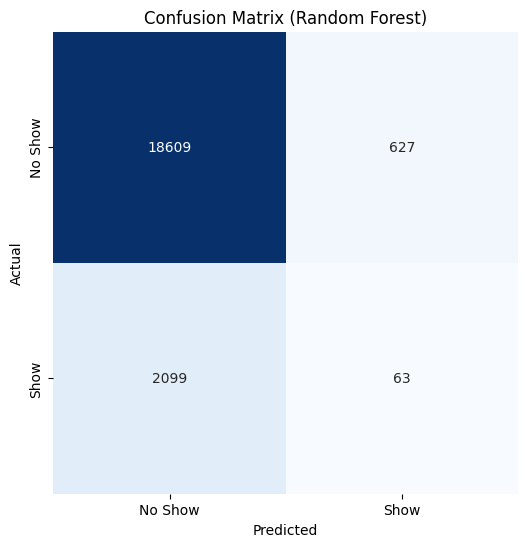

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Example: Confusion Matrix for Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train_preprocessed, y_train)
y_pred = model.predict(X_test_preprocessed)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Show', 'Show'],
            yticklabels=['No Show', 'Show'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# **Feature Importance**
Feature importance shows which features contribute most to the model's predictions. This is particularly useful for tree-based models like Random Forest and Gradient Boosting.

<ipython-input-21-b032220d5d79>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


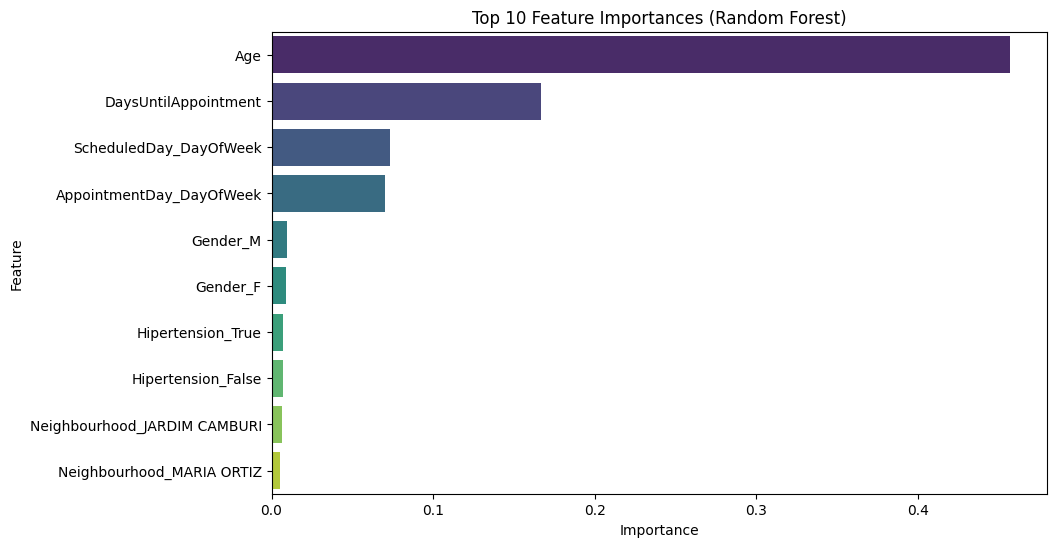

In [ ]:
# Example: Feature Importance for Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train_preprocessed, y_train)

# Get feature importances
importances = model.feature_importances_
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

<ipython-input-22-9e7c4efdf983>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


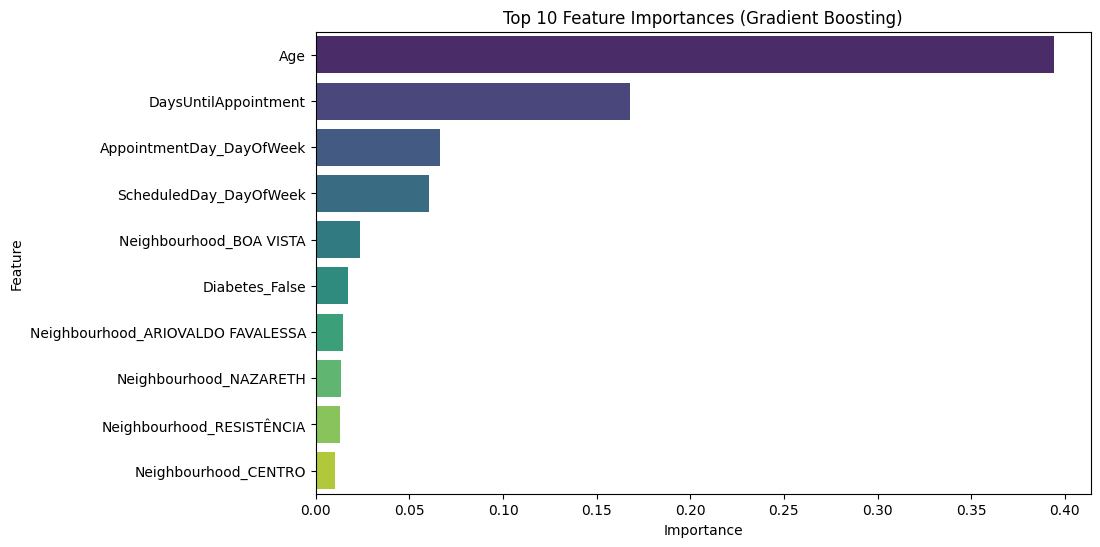

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Train the Gradient Boosting model
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train_preprocessed, y_train)

# Get feature importances
importances = model.feature_importances_

# Get feature names
feature_names = numerical_features + list(preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features))

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title('Top 10 Feature Importances (Gradient Boosting)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

Model Comparison Bar Plot

<ipython-input-24-09d150588fc7>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=dt_feature_importance_df.head(10), palette='magma')


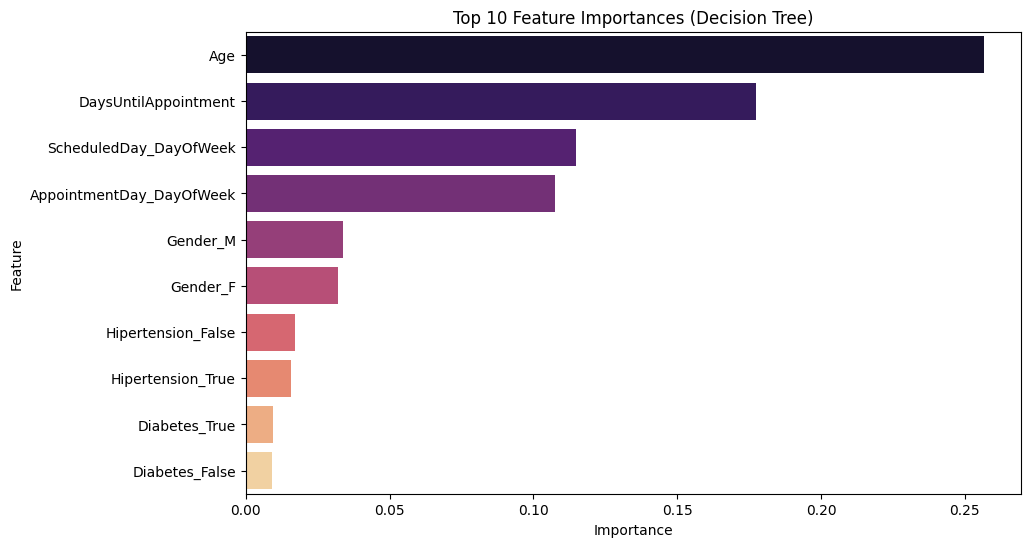

In [ ]:
# Train the Decision Tree model
from sklearn.tree import DecisionTreeClassifier

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train_preprocessed, y_train)

# Get feature importances
dt_importances = dt_model.feature_importances_

# Create a DataFrame for feature importances
dt_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': dt_importances})
dt_feature_importance_df = dt_feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=dt_feature_importance_df.head(10), palette='magma')
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


<ipython-input-25-34edc5c33540>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=lr_feature_importance_df.head(10), palette='coolwarm')


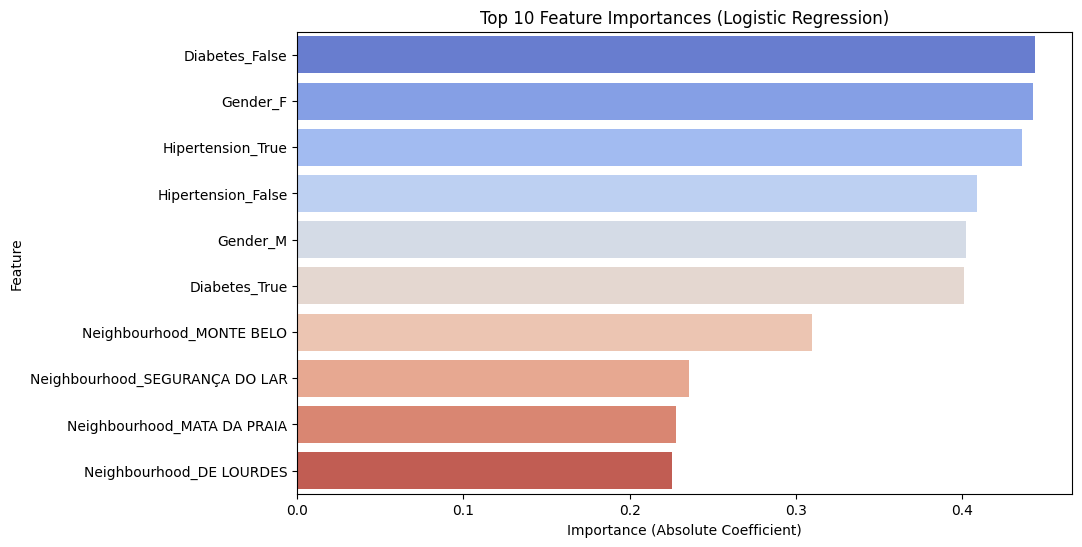

In [ ]:
# Train the Logistic Regression model
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_preprocessed, y_train)

# Get feature importances (coefficients)
lr_importances = np.abs(lr_model.coef_[0])

# Create a DataFrame for feature importances
lr_feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': lr_importances})
lr_feature_importance_df = lr_feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=lr_feature_importance_df.head(10), palette='coolwarm')
plt.title('Top 10 Feature Importances (Logistic Regression)')
plt.xlabel('Importance (Absolute Coefficient)')
plt.ylabel('Feature')
plt.show()


<Figure size 1000x600 with 0 Axes>

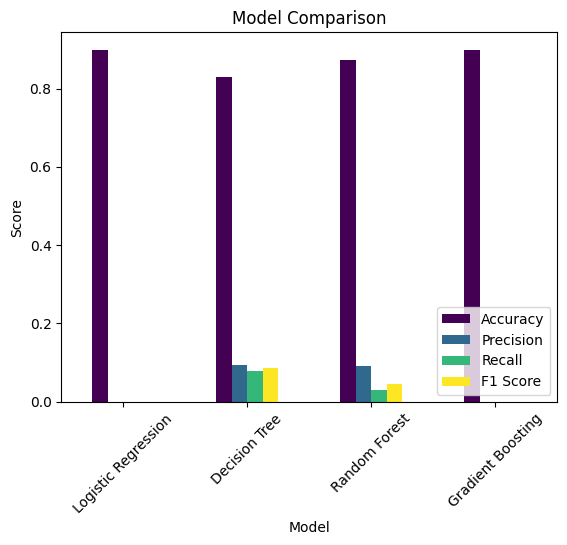

In [ ]:
import pandas as pd

# Example: Model Comparison
metrics_df = pd.DataFrame(results).T

# Plot model comparison
plt.figure(figsize=(10, 6))
metrics_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar', colormap='viridis')
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()

 Saving the Trained Model and Preprocessor

In [ ]:
import joblib

# Save the trained Gradient Boosting model
joblib.dump(model, 'gradient_boosting_model.pkl')

# Save the preprocessor
joblib.dump(preprocessor, 'preprocessor.pkl')

Load the Model and Preprocessor

In [ ]:
import joblib

# Load the trained Gradient Boosting model
model = joblib.load('gradient_boosting_model.pkl')

# Load the preprocessor
preprocessor = joblib.load('preprocessor.pkl')

Create a Prediction Function

In [ ]:
import pandas as pd

def predict_patient_show_up(new_data, model, preprocessor):
    """
    Predict whether a new patient will show up for their appointment.

    Parameters:
    - new_data: DataFrame containing new patient data.
    - model: Trained Gradient Boosting model.
    - preprocessor: Preprocessor used during training.

    Returns:
    - predictions: List of predictions (1 for show-up, 0 for no-show).
    - probabilities: List of probabilities for showing up.
    """
    # Preprocess the new data
    new_data_preprocessed = preprocessor.transform(new_data)

    # Make predictions
    predictions = model.predict(new_data_preprocessed)

    # Get probabilities for showing up (class 1)
    probabilities = model.predict_proba(new_data_preprocessed)[:, 1]

    return predictions, probabilities

Generate a List of Likely Patients

In [ ]:
# Example new patient data
new_patient_data = pd.DataFrame({
    'Gender': ['F', 'M', 'F'],
    'Age': [45, 30, 60],
    'Neighbourhood': ['Neighbourhood_A', 'Neighbourhood_B', 'Neighbourhood_C'],
    'Scholarship': [0, 1, 0],
    'Hipertension': [1, 0, 1],
    'Diabetes': [0, 1, 0],
    'ScheduledDay_DayOfWeek': [3, 4, 2],
    'ScheduledDay_Hour': [10, 14, 9],
    'AppointmentDay_DayOfWeek': [4, 5, 3],
    'DaysUntilAppointment': [5, 2, 7]
})

Make Predictions

In [ ]:
# Make predictions for new patient data
predictions, probabilities = predict_patient_show_up(new_patient_data, model, preprocessor)

# Add predictions and probabilities to the new patient data
new_patient_data['Prediction'] = predictions
new_patient_data['Probability'] = probabilities

# Display the results
print(new_patient_data)

 Generate a List of Most Likely Patients

In [ ]:
# Sort patients by probability of showing up (descending order)
most_likely_patients = new_patient_data.sort_values(by='Probability', ascending=False)

# Display the top patients
print("Most Likely Patients to Show Up:")
print(most_likely_patients[['Gender', 'Age', 'Neighbourhood', 'Probability']])